# Contexte : Home Credit Default Risk Competition

Pour accorder un crédit à la consommation, l’entreprise souhaite mettre en œuvre un outil de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non, puis classifie la demande : crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification pour aider à décider si un prêt peut être accordé à un client.

Les chargés de relation client seront les utilisateurs de l’outil de scoring. Puisqu’ils s’adressent aux clients, ils ont besoin que votre modèle soit facilement interprétable. Les chargés de relation souhaitent, en plus, disposer d’une mesure de l’importance des variables qui ont poussé le modèle à donner cette probabilité à un client.


# Data
Les données sont fournies par Home Credit, un service dédié aux crédits à la population.

Il y a 7 sources de données différentes :

* application_train\application_test : les données principales d'entraînement et de test avec des informations sur chaque demande de prêt chez Home Credit. Chaque prêt a sa propre ligne et est identifié par la caractéristique SK_ID_CURR. Les données de demande d'application d'entraînement sont accompagnées de la TARGET indiquant 0 : le prêt a été remboursé ou 1 : le prêt n'a pas été remboursé.
* bureau : données concernant les crédits précédents des clients provenant d'autres institutions financières. Chaque crédit précédent a sa propre ligne dans le bureau, mais un prêt dans les données de demande peut avoir plusieurs crédits précédents.
* bureau_balance : données mensuelles sur les crédits précédents dans le bureau. Chaque ligne est un mois d'un crédit précédent, et un seul crédit précédent peut avoir plusieurs lignes, une pour chaque mois de la durée du crédit.
* previous_application : demandes précédentes de prêts chez Home Credit de clients ayant des prêts dans les données de demande. Chaque prêt actuel dans les données de demande peut avoir plusieurs prêts précédents. Chaque demande précédente a une ligne et est identifiée par la caractéristique SK_ID_PREV.
* POS_CASH_BALANCE : données mensuelles sur les précédents points de vente ou prêts en espèces que les clients ont eus avec Home Credit. Chaque ligne est un mois d'un précédent point de vente ou prêt en espèces, et un seul prêt précédent peut avoir de nombreuses lignes.
* credit_card_balance : données mensuelles sur les anciennes cartes de crédit que les clients ont eues avec Home Credit. Chaque ligne est un mois d'un solde de carte de crédit, et une seule carte de crédit peut avoir de nombreuses lignes.
* installments_payment : historique des paiements pour les prêts précédents chez Home Credit. Il y a une ligne pour chaque paiement effectué et une ligne pour chaque paiement manqué.


Les définitions des variables sont disponibles dans `HomeCredit_columns_description.csv`

Dans ce notebook nous n'utiliserons que le fichier principal "application_train".

Ce travail est basé sur le kernet préconisé : l start-here-a-gentle-introduction (kaggle)


## Imports
Nous utiliserons les library standard de datascience : `numpy`, `pandas`, `sklearn`, `matplotlib`. 

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform
import xgboost as xgb
from sklearn import svm
# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE 


pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
def inspect_dupes(df, dedupe=False):
    '''
    Checks duplicates (rows), and gets rid of duplicates if dedupe arg set to 'True' 
    Arg: dataframe, dedupe (bool)
    '''
    num_of_dupe = len(df[df.duplicated()])

    if dedupe and num_of_dupe>0: 
        df.drop_duplicates(inplace=True)
        print(f'Number of duplicates found: {num_of_dupe}')
        return df

    else: 
        print(f'Number of duplicates found: {num_of_dupe}')
        return num_of_dupe
    
def iqr(df,drop=False):
   
    cols_to_keep = [col for col in df.columns if df[col].nunique() > 2]
    dataframe = df[cols_to_keep]
    
    iqr_analysis_list = []

    # Sélection des variables numériques
    numeric_variables = dataframe.select_dtypes(include=['number'])
    l_ind_outlier=[]
    
    for variable_name in numeric_variables.columns:
        # Calcul de l'analyse IQR pour chaque variable numérique
        variable_data = dataframe[variable_name]
        
        # Calcul des quartiles
        Q1 = variable_data.quantile(0.25)
        Q3 = variable_data.quantile(0.75)
        
        # Calcul de l'IQR (Interquartile Range)
        IQR = Q3 - Q1
        
        # Détermination des limites inférieure et supérieure pour détecter les valeurs aberrantes
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Exclusion des individus aberrants
        excluded_count = ((variable_data < lower_bound) | (variable_data > upper_bound)).sum()
        
        # Calcul du ratio d'exclusion
        total_count = len(variable_data)
        exclusion_ratio = excluded_count / total_count
        
        # Ajout des résultats dans une liste
        iqr_analysis_list.append({
            'Variable': variable_name,
            'Q1': Q1,
            'Q3': Q3,
            'IQR': IQR,
            'Lower Bound': lower_bound,
            'Upper Bound': upper_bound,
            'Excluded Count': excluded_count,
            'Exclusion Ratio': exclusion_ratio
        })

        # Filtrer les valeurs en dehors des bornes IQR
        l_ind_outlier += dataframe[(dataframe[variable_name] <= lower_bound) |
                                   (dataframe[variable_name] >= upper_bound)].index.to_list()

    l_ind_outlier=set(l_ind_outlier)
    print(len(l_ind_outlier))
    
    if drop == True :
        dataframe=dataframe.drop(l_ind_outlier,axis=0)
    # Création d'un dataframe à partir de la liste des résultats
    iqr_analysis_df = pd.DataFrame(iqr_analysis_list)
    display(iqr_analysis_df.sort_values(by='Exclusion Ratio',ascending=False))
    
    return dataframe    
    
    
 # Réduit le nombre de décimale
def format_value(x):
    try:
        return f"{x:.2f}"
    except:
        return str(x)
    
  # Explorations de base du df  
def desc(df):
    print( '************************************')  
    print( '      Descriptif du dataset')
    print( '************************************')  
    print(f'Le dataset est composé de {df.shape[0]} individus et {df.shape[1]} variables.')
    display(df.head())
    display(df.dtypes)
    display(df.describe())
    display(bilan_null(df).sort_values(by='Missing ratio',ascending = True))

  # Renvoie un df avec les Nunique et des infos sur les NaN      
def bilan_null(df):
    df_bilan=pd.concat([df.nunique(),
                        df.isnull().mean(),
                        df.isnull().sum(),
                        df.notnull().sum()],
                        axis=1,
                        keys=['Nunique','Missing ratio','Null count','Notnull count'])
    return df_bilan.sort_values(by='Missing ratio')

# Fonction pour encoder les variables catégorielles
def cat_enc(df) :

    le = LabelEncoder()
    le_count = 0

    # Iterate through the columns
    for col in df:
        if df[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(df[col].unique())) <= 2:
                # Train on the training data
                le.fit(df[col])
                # Transform both training and testing data
                df[col] = le.transform(df[col])
                # Keep track of how many columns were label encoded
                le_count += 1

    print('%d columns were label encoded.' % le_count)
    # one-hot encoding of categorical variables
    df = pd.get_dummies(df,dtype=int)

    print('Training Features shape: ', df.shape)
    
    return df
def plot_target_cat(df, cat):

        plt.figure(figsize=(10, 6))
        sns.countplot(x=cat, hue="TARGET", data=df)
        plt.title("Effectifs de {} par {}".format(cat, "TARGET"))
        plt.xlabel(cat)
        if max([len(str(i)) for i in df[cat].unique()]) > 15:
            plt.xticks(rotation=45)
        if max([len(str(i)) for i in df[cat].unique()]) > 20:
            plt.xticks(rotation=90)
        plt.ylabel("Effectifs")
        plt.legend(title="TARGET", loc='upper right')
        plt.show()
        raw_df.groupby(cat)["TARGET"].mean().plot(kind='bar')    
        plt.title("Moyenne de défaut de paiement")
        if max([len(str(i)) for i in df[cat].unique()]) < 15:
            plt.xticks(rotation=0)
        if max([len(str(i)) for i in df[cat].unique()]) > 15:
            plt.xticks(rotation=45)
        if max([len(str(i)) for i in df[cat].unique()]) > 20:
            plt.xticks(rotation=90)
        plt.show()

def plot_target_num(df, numerical_column):

    # Création des bins
    df['bins'] = pd.cut(df[numerical_column], bins=11,precision=0)
    # Calcul de la moyenne de la cible pour chaque bin
    mean_target = df.groupby('bins')["TARGET"].mean()

    plt.figure(figsize=(10, 6))
    sns.countplot(x=df['bins'], hue="TARGET", data=df)
    plt.title("Effectifs de {} par {}".format(numerical_column, "TARGET"))
    plt.xlabel(numerical_column)
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 15:
        plt.xticks(rotation=45)
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 20:
        plt.xticks(rotation=90)
    plt.ylabel("Effectifs")
    plt.legend(title="TARGET", loc='upper right')
    plt.show()    
        
    
    # Tracé du barplot
    plt.figure(figsize=(10, 6))
    mean_target.plot(kind='bar')
    plt.title("Moyenne de défaut de paiement")
    plt.xlabel(numerical_column)
    plt.ylabel(('%'))
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 15:
        plt.xticks(rotation=45)
    if max([len(str(i)) for i in df[numerical_column].unique()]) > 20:
        plt.xticks(rotation=90)
    plt.show()        

def plot_roc_curves(y_true, d_res):

    plt.figure(figsize=(8, 6))
    for label in d_res :
        print(label)
        print(y_true.shape)
        print(d_res[label][2][:,1].shape)
        if label != 'DummyClassifier' :
            fpr, tpr, _ = roc_curve(y_true, d_res[label][2][:,1])
            auc = roc_auc_score(y_true, d_res[label][2][:,1])
            plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('Taux de faux positifs (FPR)')
    plt.ylabel('Taux de vrais positifs (TPR)')
    plt.title('Courbes ROC')
    plt.legend()
    plt.show()
    
def make_confusion_matrix(y_true,
                          y_pred,
                          y_pred_proba=0,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']

    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''

    cf=confusion_matrix(y_true, y_pred)

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks
    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks
    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks
    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1,1] / np.sum(cf[:,1])
            recall    = cf[1,1] / np.sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            HC_score  = custom_cost(y_true,y_pred)
            auc       = roc_auc_score(y_true, y_pred_proba)
            stats_text = '''
           
HC Score  = {:0.3f}
Accuracy  = {:0.3f}
Precision = {:0.3f}
Recall    = {:0.3f}
F1 Score  = {:0.3f}
                 
ROC AUC   = {:0.3f}
                        '''.format(
                HC_score, accuracy, precision, recall, f1_score, auc)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

def custom_cost(y_ref, y_pred):
    # Assigner des poids aux erreurs
    FP_cost = 1  # Coût d'un faux positif
    FN_cost = 10   # Coût d'un faux négatif
    TP_cost = 10   # Coût d'un vrai positif
    TN_cost = 10   # Coût d'un faux positif
    
    # Calculer le nombre de faux positifs et de faux négatifs
    FP_count = sum((y_ref == 0) & (y_pred == 1))
    FN_count = sum((y_ref == 1) & (y_pred == 0))
    TP_count = sum((y_ref == 1) & (y_pred == 1))
    TN_count = sum((y_ref == 0) & (y_pred == 0))  
    
    Total_count = y_ref.shape[0]
    
    # Calculer le coût total
    total_cost = (TP_count*TP_cost +  TN_count*TN_cost - FP_count*FP_cost - FN_count*FN_cost)/(TP_count*TP_cost +  TN_count*TN_cost + FP_count*FP_cost + FN_count*FN_cost)
        
    return total_cost

def search_score(titre, model,  param, n_job, X_train, y_train, X_test, y_test) :
   
    clf = model 
    
    param_grid = param

    model_opt = RandomizedSearchCV(clf,
                                   param_grid,
                                   cv=2,
                                   n_iter=200,
                                   verbose=1,
                                   scoring=HC_scorer,
                                   n_jobs=n_job,
                                   random_state=42,
                                   refit=True )
    
    model_opt = model_opt.fit(X_train, y_train)


    fpr, tpr, thr = roc_curve(y_test, model_opt.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    
    y_true= y_test
    y_pred = model_opt.predict(X_test)
    y_pred_proba = model_opt.predict_proba(X_test)[:,1]
    
    make_confusion_matrix(y_true, y_pred,  y_pred_proba=y_pred_proba)
    
    d_res[titre]=[
                    roc_auc,
                    custom_cost(y_test,model_opt.predict(X_test)),
                    model_opt.predict_proba(X_test)
                   ]    
   
    results = model_opt.cv_results_

    # Créer un DataFrame avec les informations pertinentes
    df_results = pd.DataFrame({
        'rank_test_score': results['rank_test_score'],
        'mean_test_score': results['mean_test_score'],
        'params': results['params']
    })
    # Extraire les paramètres individuels
    params_df = pd.json_normalize(df_results['params'])

    # Combiner les résultats avec les paramètres
    df_results_combined = pd.concat([df_results.drop(columns=['params']), params_df], axis=1)

    # Trier le DataFrame par rang
    df_results_sorted = df_results_combined.sort_values(by='rank_test_score')


    # Afficher les trois meilleurs résultats
    top_5_results = df_results_sorted.head(5)

    # Afficher les résultats sous forme de tableau
    display(top_5_results)
    
    return model_opt

##  Chargement des données

Commençons par visualiser le dataset préprocessé par le notebook d'EDA :'app_train_clean.csv' : 

In [3]:
# Training data
raw_df = pd.read_csv('C:\\Users\Cecil\\Desktop\\Formation\\4_Credit_scoring\\app_train_clean.csv')

app_train=raw_df.copy()
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 224)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,...,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TY

# Méthodologie pour l'apprentissage supervisé

Nous allons étudier plusieurs modèles, du plus simple au plus compliqué :
* dummyclassifier, qui renvoie la valeur la plus probable
* Logistic Regression
* RandomForest
* XGboost

L'évaluation des scores doit être basée sur un score personnalisé afin de satisfaire le besoin client :
les faux négatifs coutent dix fois plus cher que les faux positifs, i.e. un client qui est prédit capable de rembourser alors qu'il ne le sera pas va couter plus cher qu'un client a qui on accordera pas le prêt alors qu'il en aurait la capacité de remboursement.

Commençons par définir le nouveau score :

In [4]:


HC_scorer = make_scorer(custom_cost)



# Gestion des données manquantes

L'âge permet de bien réprésenter une population, nous imputons les valeurs manquantes par tranche d'âge :
* les valeurs numériques sont remplacées par la médiane,
* les valeurs catégoriques  par le mode le plus représenté.

Afin de limiter le temps de calcul, nous entrainerons les modèles sur un échantillons de 20 000 individus.


In [5]:
n_test = 19999

X = app_train.loc[0:n_test,:].copy()
y = X['TARGET']

X.drop('TARGET',inplace=True, axis=1)
X.drop('SK_ID_CURR',inplace=True, axis=1)


# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# imputation
for datas in [X_train,X_test] :
    datas['age_group']  = pd.cut(datas['DAYS_BIRTH'].divide(365), bins=np.linspace(20, 70, num = 11))


    numeric_cols  =  datas.select_dtypes(include='number')
    cat_cols      =  datas.select_dtypes(exclude='number')

    for cat in datas['age_group'].unique() :
        for c in numeric_cols:
            datas.loc[datas['age_group'] == cat, c] = datas.loc[datas['age_group'] == cat, c].fillna(datas.loc[datas['age_group'] == cat, c].median())

        for c in cat_cols:
            datas.loc[datas['age_group'] == cat, c] = datas.loc[datas['age_group'] == cat, c].fillna(datas.loc[datas['age_group'] == cat, c].mode()[0])

    datas.drop(columns=['age_group'],inplace=True)
    display(bilan_null(datas))
    


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)



,Nunique,Missing ratio,Null count,Notnull count
NAME_CONTRACT_TYPE,2,0.0,0,16000
OCCUPATION_TYPE_Secretaries,2,0.0,0,16000
OCCUPATION_TYPE_Security staff,2,0.0,0,16000
OCCUPATION_TYPE_Waiters/barmen staff,2,0.0,0,16000
WEEKDAY_APPR_PROCESS_START_FRIDAY,2,0.0,0,16000
...,...,...,...,...
FLAG_DOCUMENT_15,2,0.0,0,16000
FLAG_DOCUMENT_16,2,0.0,0,16000
FLAG_DOCUMENT_17,2,0.0,0,16000
FLAG_DOCUMENT_6,2,0.0,0,16000


,Nunique,Missing ratio,Null count,Notnull count
NAME_CONTRACT_TYPE,2,0.0,0,4000
OCCUPATION_TYPE_Secretaries,2,0.0,0,4000
OCCUPATION_TYPE_Security staff,2,0.0,0,4000
OCCUPATION_TYPE_Waiters/barmen staff,2,0.0,0,4000
WEEKDAY_APPR_PROCESS_START_FRIDAY,2,0.0,0,4000
...,...,...,...,...
FLAG_DOCUMENT_15,2,0.0,0,4000
FLAG_DOCUMENT_16,2,0.0,0,4000
FLAG_DOCUMENT_17,2,0.0,0,4000
FLAG_DOCUMENT_6,2,0.0,0,4000


Les résultats seront stockés dans le dictionnaire : d_res.

In [6]:
d_res={}
n_job=3

Nous enchainons ensuite par la création de notre dummyclassifier :

In [7]:
%%time

# Pipeline for du Classifier

dc = DummyClassifier(strategy='most_frequent')

# Fit and evaluate du Classifier
dc.fit(X_train_scaled, y_train)

fpr, tpr, thr = roc_curve(y_test, dc.predict_proba(X_test_scaled)[:,1])
roc_auc = auc(fpr, tpr)

y_pred=dc.predict(X_test_scaled)

print(roc_auc)
print(custom_cost(y_test,dc.predict(X_test_scaled)))



0.5
0.837
CPU times: total: 0 ns
Wall time: 6 ms


In [8]:
X_train_scaled.shape

(16000, 222)

Nous réalisons ensuite un modèle de régression logistique avec deux méthodes de rééquilibrage des classes : 
* class_weight = 'balanced'
* SMOTE

(29496, 222) (29496,) (4000, 222) (4000,)
Fitting 2 folds for each of 200 candidates, totalling 400 fits


,rank_test_score,mean_test_score,solver,penalty,max_iter,C
154,1,0.668483,liblinear,l1,400,100.0
79,2,0.668471,newton-cg,l2,400,100.0
42,2,0.668471,newton-cg,l2,500,100.0
158,2,0.668471,newton-cg,l2,100,100.0
40,5,0.667998,saga,l1,500,10.0


Fitting 2 folds for each of 200 candidates, totalling 400 fits


,rank_test_score,mean_test_score,solver,penalty,max_iter,C
15,1,0.854679,sag,l2,500,10.0
178,2,0.850374,saga,l1,300,0.1
7,2,0.850374,saga,l1,200,0.1
4,2,0.850374,saga,l1,100,0.1
51,5,0.849802,liblinear,l1,500,0.1


CPU times: total: 3min 36s
Wall time: 19min 12s


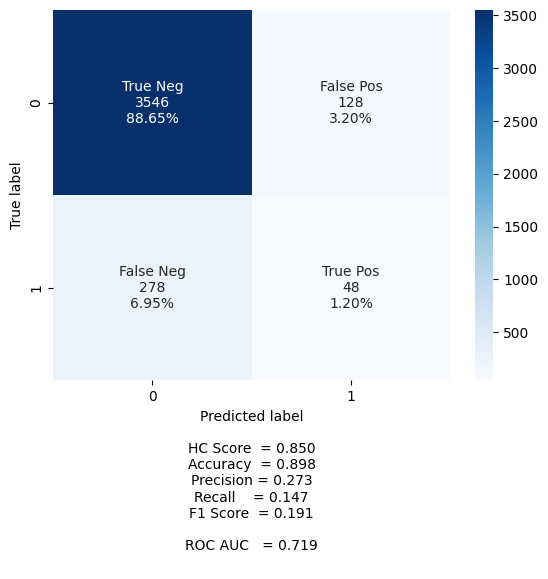

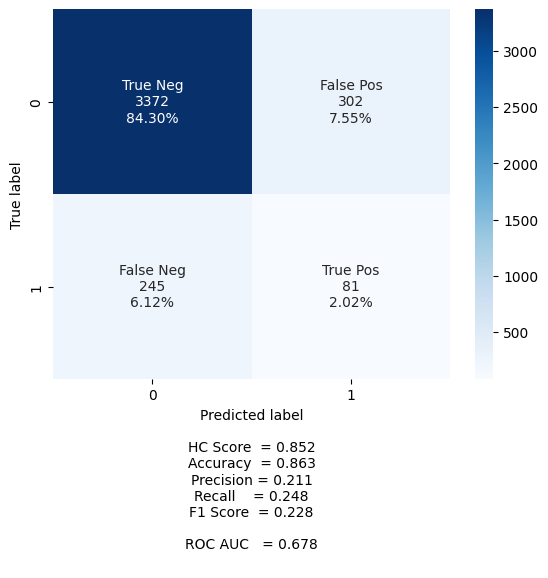

In [9]:
%%time

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [100, 200, 300, 400, 500]
    
}

oversample = SMOTE()
X_train_smoted, y_train_smoted = oversample.fit_resample(X_train_scaled, y_train)

print(X_train_smoted.shape, y_train_smoted.shape, X_test_scaled.shape, y_test.shape)

# avec équilibrage smote
lr_smote = search_score('lr_smote',
                      LogisticRegression(),
                      param_grid,
                      n_job,
                      X_train_smoted, y_train_smoted, X_test_scaled, y_test)

lr_weight = search_score('lr_weight',
                      LogisticRegression(class_weight = 'balanced'),
                      param_grid,
                      n_job,
                      X_train_scaled, y_train, X_test_scaled, y_test)



Nous obtenons un score métier de 0.853 à l'optimum des paramètres déterminés par randomizedsearch.

Essayons un nouveau modèle XGradientBoostingClassifier :


Fitting 2 folds for each of 200 candidates, totalling 400 fits


,rank_test_score,mean_test_score,subsample,random_state,n_estimators,min_child_weight,max_depth,learning_rate,gamma,colsample_bytree
62,1,0.912638,0.7,42,400,1,9,0.05,0.0,0.6
111,2,0.912624,0.9,42,400,1,11,0.05,0.2,0.9
131,3,0.912303,0.8,42,500,2,11,0.15,0.0,0.7
61,4,0.912302,0.8,42,500,1,9,0.20,0.2,0.8
166,5,0.912267,0.8,42,400,1,11,0.05,0.2,0.6


Fitting 2 folds for each of 200 candidates, totalling 400 fits


,rank_test_score,mean_test_score,subsample,random_state,n_estimators,min_child_weight,max_depth,learning_rate,gamma,colsample_bytree
87,1,0.867065,0.7,42,400,2,5,0.01,0.4,0.6
32,2,0.866603,0.8,42,400,4,7,0.01,0.2,1.0
13,3,0.866363,0.6,42,300,5,7,0.01,0.4,0.9
28,4,0.865898,0.7,42,300,1,3,0.05,0.3,0.9
180,5,0.865599,0.9,42,500,3,7,0.01,0.1,0.8


CPU times: total: 3min 11s
Wall time: 24min 29s


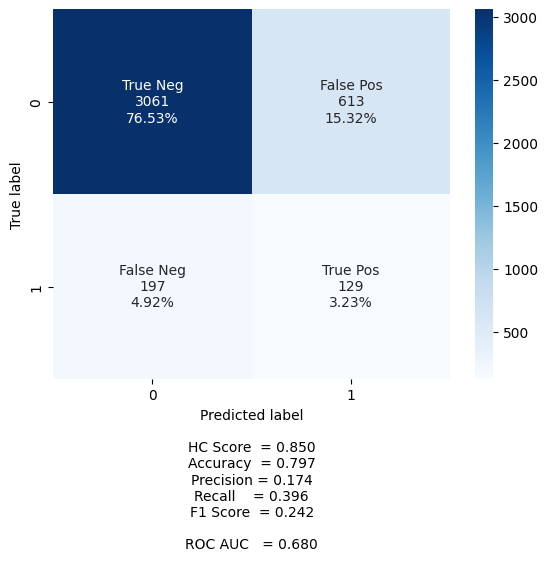

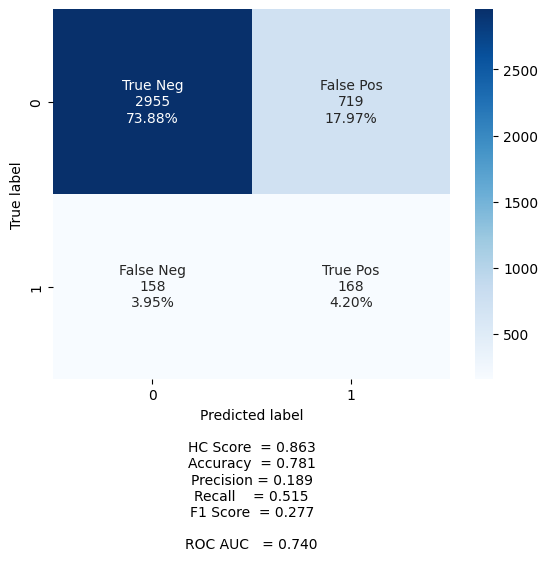

In [10]:
%%time

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 5, 7, 9, 11],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5],
    'random_state' : [42]
}

# balanced
xg_smote = search_score('xg_smote',
                      xgb.XGBClassifier(),
                      param_grid,
                      n_job,             
                      X_train_smoted, y_train_smoted, X_test_scaled, y_test)

xg_weight = search_score('xg_weight',
                      xgb.XGBClassifier(scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()),
                      param_grid,
                      n_job,             
                      X_train_scaled, y_train,       X_test_scaled, y_test)




Nous obtenons un score métier de 0.863 à l'optimum des paramètres déterminés par randomizedsearch.

Essayons un nouveau modèle RandomForestClassifier :

Fitting 2 folds for each of 200 candidates, totalling 400 fits


,rank_test_score,mean_test_score,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap
66,1,0.924712,400,2,1,sqrt,20.0,False
169,2,0.924317,200,2,1,log2,20.0,False
180,3,0.923415,500,2,1,sqrt,20.0,True
153,4,0.923182,100,2,1,log2,40.0,False
100,5,0.922704,500,2,1,log2,50.0,True


Fitting 2 folds for each of 200 candidates, totalling 400 fits


,rank_test_score,mean_test_score,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap
46,1,0.862853,400,10,4,sqrt,10.0,False
87,2,0.861847,300,5,4,sqrt,10.0,False
68,3,0.861603,500,10,1,sqrt,10.0,True
93,4,0.861558,400,2,4,sqrt,10.0,False
124,5,0.861362,400,10,2,sqrt,10.0,True


CPU times: total: 55.4 s
Wall time: 26min 45s


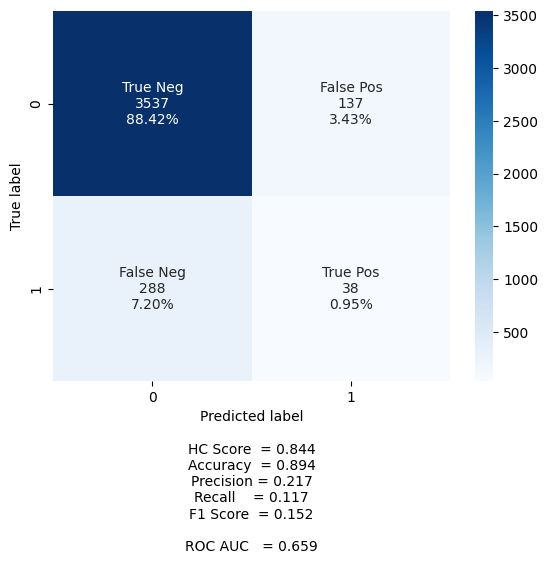

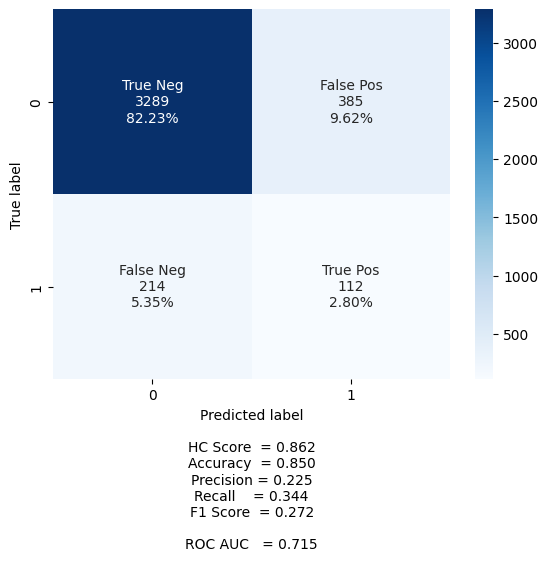

In [11]:
%%time

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# balanced
rf_smote = search_score('rf_smote',
                       RandomForestClassifier(),
                       param_grid,
                       n_job,             
                       X_train_smoted, y_train_smoted, X_test_scaled, y_test)
 
rf_weight=search_score('rf_weight',
                      RandomForestClassifier(class_weight='balanced'),
                      param_grid,
                      n_job,             
                      X_train_scaled, y_train,         X_test_scaled, y_test)





Nous obtenons un score métier de 0.861, légèrement moins bon qu'avec le classifier précédent.

Examinons les courbes ROC :

lr_smote
(4000,)
(4000,)
lr_weight
(4000,)
(4000,)
xg_smote
(4000,)
(4000,)
xg_weight
(4000,)
(4000,)
rf_smote
(4000,)
(4000,)
rf_weight
(4000,)
(4000,)


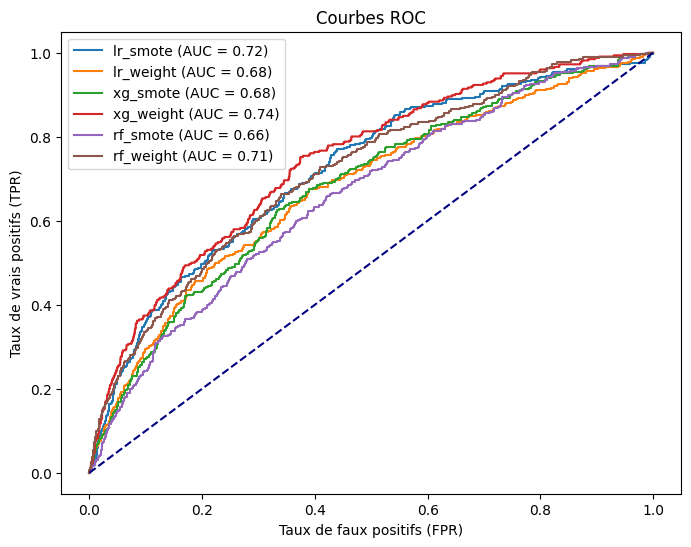

In [12]:
plot_roc_curves(y_test, d_res)

Les résultats sont relativements proches. Les paramètres optimaux dépendent d'un RandomizedSearchCV avec 400 fits, il est possible que les meilleurs paramètres possibles ne soient pas parfaitement atteint, toutefois la meilleure combinaison sur les paramètres testés aléatoirement reste une bonne approximation des "meilleurs paramètres possibles" que nous aurions pu atteindre avec un gridsearch lancé sur plusieurs heures/jours de calcul. Ceci est prouvé empiriquement par l'article : https://www.jmlr.org/papers/v13/bergstra12a.html

Comparons maintenant les scores métiers :

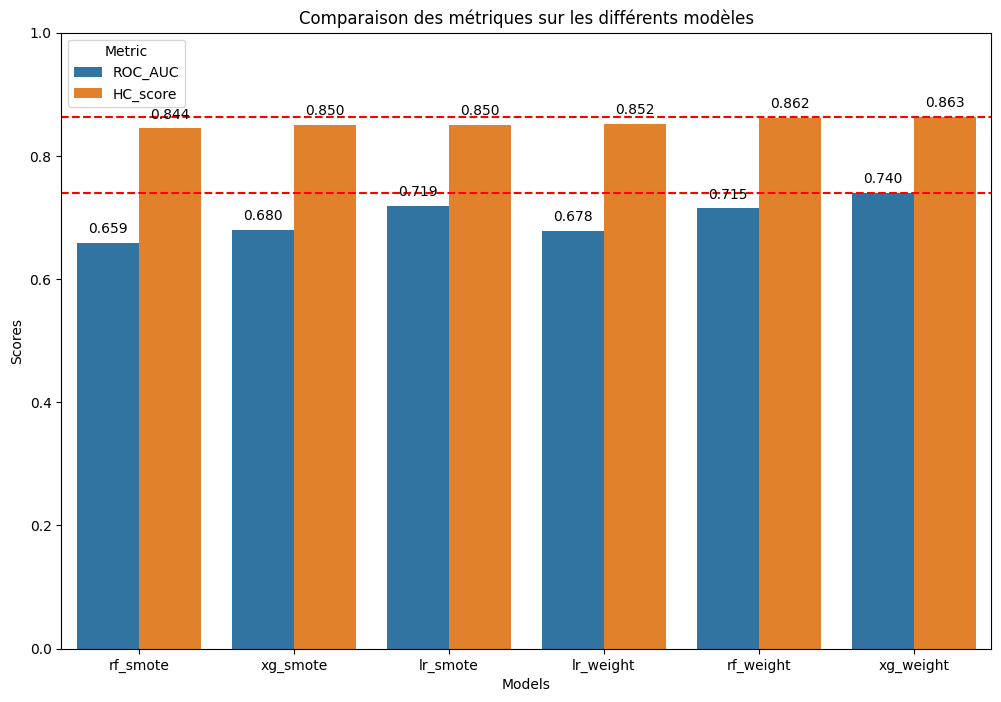

In [13]:
# Metrics labels
metrics = ['ROC_AUC', 'HC_score']

# Convert the dictionary to a DataFrame for easier plotting
d_plot = {key: d_res[key][0:2] for key in d_res}


df = pd.DataFrame.from_dict(d_plot, orient='index', columns=metrics).sort_values(by='HC_score')
# df=df.iloc[:,:-1]
# df.drop('DummyClassifier',inplace=True)

df.reset_index(inplace=True)
df = df.rename(columns={'index': 'Model'})
max_HC_score  = df.HC_score.max()
max_AUC_score = df.ROC_AUC.max()


# Melt the DataFrame to a long format for seaborn
df = df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create the plot
plt.figure(figsize=(12, 8))
ax=sns.barplot(data=df, x='Model', y='Score', hue='Metric')



# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparaison des métriques sur les différents modèles')
plt.legend(title='Metric')

for p in ax.patches[:-2]:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

# Tracer une ligne en pointillé rouge au niveau du maximum de HC_score
plt.axhline(y=max_HC_score,              color='r', linestyle='--')
plt.axhline(y=max_AUC_score, color='r', linestyle='--')
# Show the plot
plt.ylim(0, 1)
plt.show()


### Conclusion 

Le modèle XGboost avec class weight a les meilleurs résultats avec un score métier de 0.863 et un ROC de 0.740.

Nous allons a présent essayer d'améliorer le modèle en choisissant un seuil de décision différent afin d'améliorer le HC_score.

## Ajustement du seuil de décision  

La variation du seuil de décision va entrainer une répartition différente des catégories prédites. 

Plus le seuil sera bas plus il y aura de valeurs positives prédites. Par extension, un seuil bas peut permettre de limiter les false negative qui seraient très couteux pour la société de crédit. En contrepartie, il y aura également une perte du nombre de true negative, qui représente les clients avec de bons profils. L'équilibre doit être trouvé en se basant sur l'expertise métier.

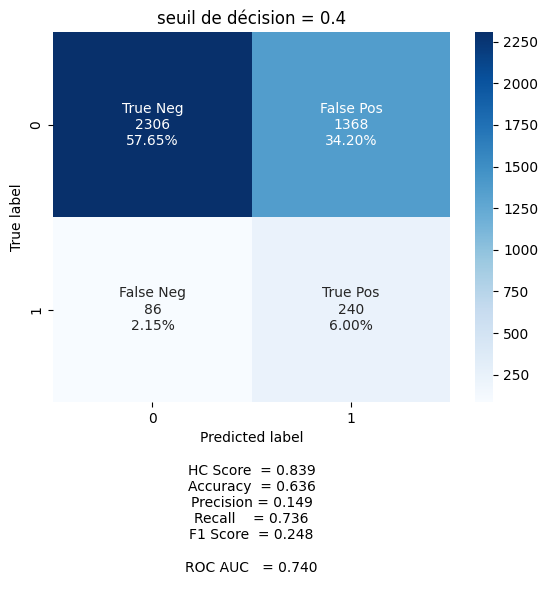

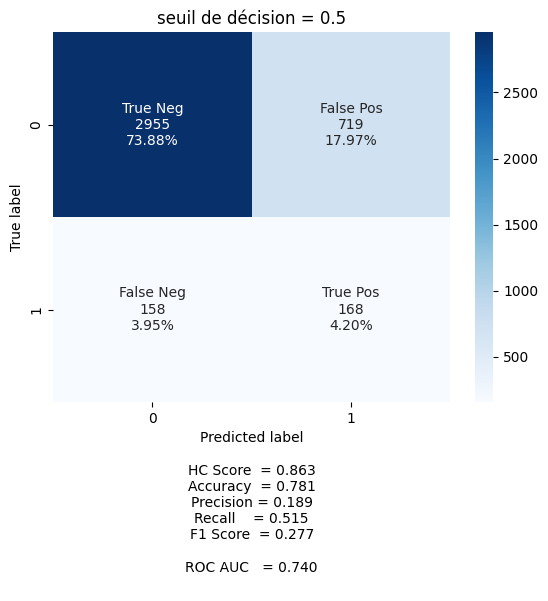

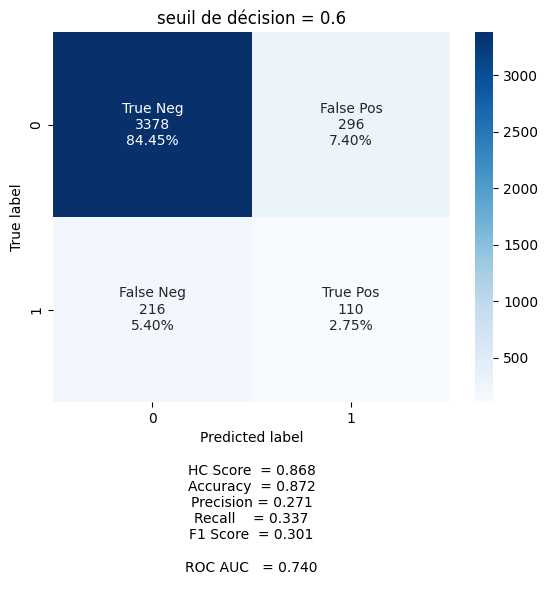

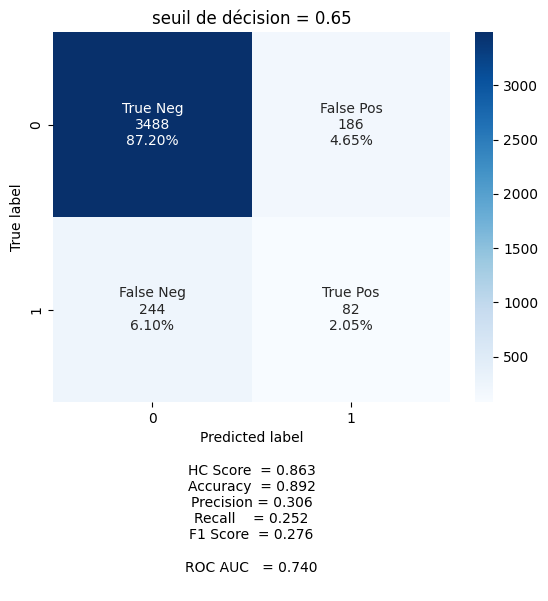

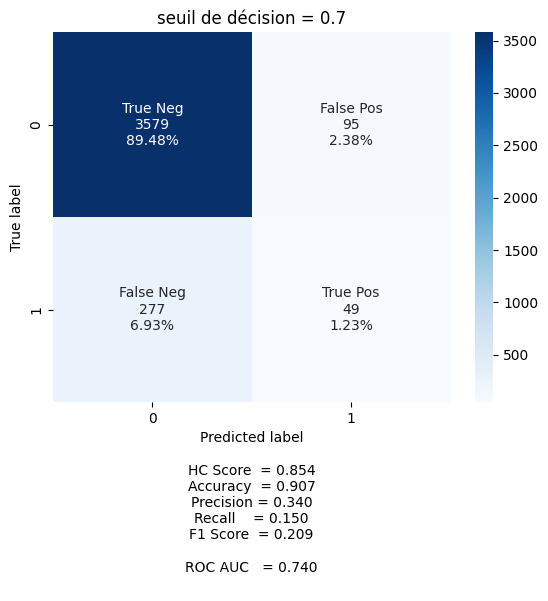

In [14]:
dec_thre = [0.4,0.5, 0.6, 0.65, 0.7]

for t in dec_thre :
    y_pred_proba = xg_weight.predict_proba(X_test_scaled)[:,1]
    y_pred       = (y_pred_proba>t).astype(int)
    y_true = y_test
    make_confusion_matrix(y_true, y_pred, y_pred_proba)
    plt.title('seuil de décision = '+ str(t))

Le score le plus élevé est obtenu pour un seuil de 0.6. Ce seuil doit être discuter avec les métiers pour consolider l'impact financier qu'il pourrait avoir.
Regardons également ce qui se produit sur le second meilleur modèle :

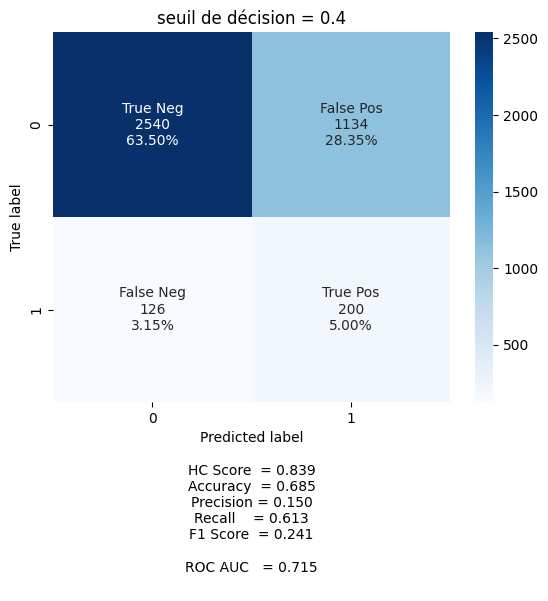

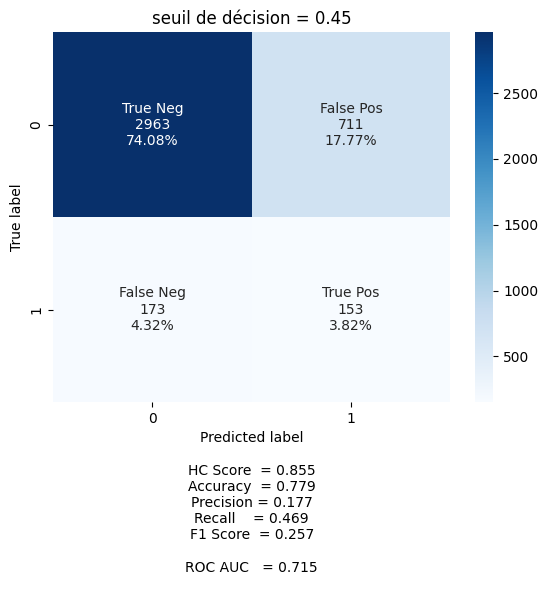

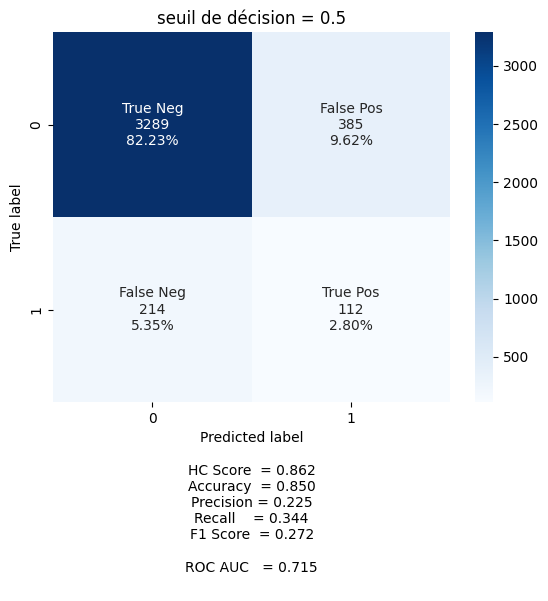

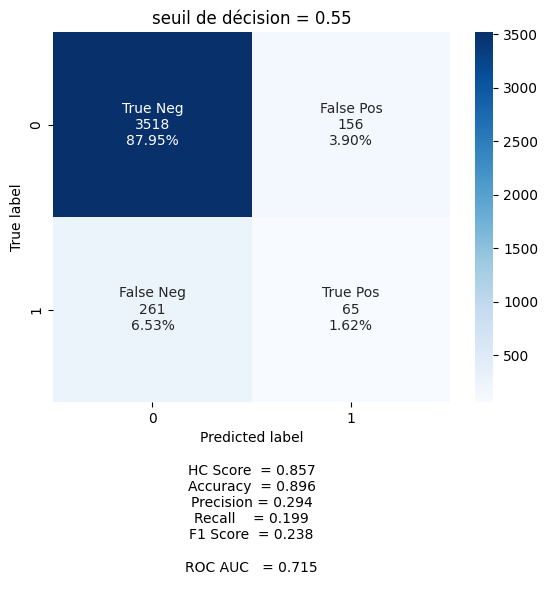

In [15]:
dec_thre = [0.4, 0.45, 0.5, 0.55]

for t in dec_thre :
    y_pred_proba = rf_weight.predict_proba(X_test_scaled)[:,1]
    y_pred       = (y_pred_proba>t).astype(int)
    y_true = y_test
    make_confusion_matrix(y_true, y_pred, y_pred_proba)
    plt.title('seuil de décision = '+ str(t))

Le seuil avec le score le plus élevé est 0.5.

# Feature Engineering

Choisir le bon modèle et les paramètres optimaux est important, mais le modèle ne peut apprendre que des données qui lui sont fournies. S'assurer que ces données sont aussi pertinentes que possible pour la tâche est le travail du data scientist (et peut-être de certains outils automatisés pour nous aider).


Nous allons utiliser les features suivantes certaines provenant de https:\\\\www.kaggle.com\\jsaguiar\\updated-0-792-lb-lightgbm-with-simple-features :

* 'CREDIT_INCOME_PERCENT' : ratio d'endettement
* 'ANNUITY_INCOME_PERCENT' : pourcentage de l'annuité du prêt par rapport au revenu d'un client
* 'ANNUITY_CREDIT_PERCENT' :  pourcentage de remboursement annuel
* 'DAYS_EMPLOYED_PERCENT' : ratio temps travaillé/age
* 'INCOME_PER_PERSON' : ratio revenu / nombre de personne vivant dans la famille




In [16]:
X.shape

(20000, 222)

,Nunique,Missing ratio,Null count,Notnull count
NAME_CONTRACT_TYPE,2,0.0,0,16000
WEEKDAY_APPR_PROCESS_START_FRIDAY,2,0.0,0,16000
WEEKDAY_APPR_PROCESS_START_MONDAY,2,0.0,0,16000
WEEKDAY_APPR_PROCESS_START_SATURDAY,2,0.0,0,16000
WEEKDAY_APPR_PROCESS_START_SUNDAY,2,0.0,0,16000
...,...,...,...,...
FLAG_DOCUMENT_17,2,0.0,0,16000
FLAG_DOCUMENT_18,2,0.0,0,16000
FLAG_DOCUMENT_19,2,0.0,0,16000
LANDAREA_MEDI,1832,0.0,0,16000


,Nunique,Missing ratio,Null count,Notnull count
NAME_CONTRACT_TYPE,2,0.0,0,4000
WEEKDAY_APPR_PROCESS_START_FRIDAY,2,0.0,0,4000
WEEKDAY_APPR_PROCESS_START_MONDAY,2,0.0,0,4000
WEEKDAY_APPR_PROCESS_START_SATURDAY,2,0.0,0,4000
WEEKDAY_APPR_PROCESS_START_SUNDAY,2,0.0,0,4000
...,...,...,...,...
FLAG_DOCUMENT_17,2,0.0,0,4000
FLAG_DOCUMENT_18,2,0.0,0,4000
FLAG_DOCUMENT_19,2,0.0,0,4000
LANDAREA_MEDI,913,0.0,0,4000


Fitting 2 folds for each of 200 candidates, totalling 400 fits


,rank_test_score,mean_test_score,subsample,random_state,n_estimators,min_child_weight,max_depth,learning_rate,gamma,colsample_bytree
0,1,0.868332,0.6,42,500,2,5,0.01,0.0,0.7
30,2,0.867623,0.7,42,100,3,7,0.01,0.0,0.8
13,3,0.867083,0.6,42,300,5,7,0.01,0.4,0.9
87,4,0.866587,0.7,42,400,2,5,0.01,0.4,0.6
32,5,0.866562,0.8,42,400,4,7,0.01,0.2,1.0


CPU times: total: 21.3 s
Wall time: 4min 51s


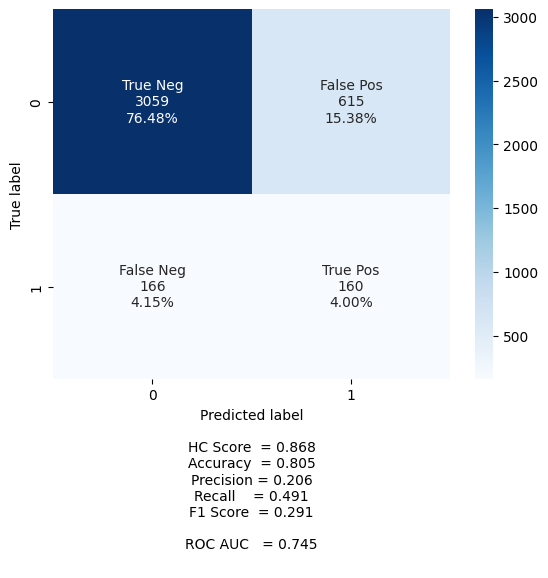

In [17]:
%%time

app_train_FE = app_train.loc[0:n_test,:].copy()

app_train_FE['CREDIT_INCOME_PERCENT']  = app_train_FE['AMT_CREDIT'] / app_train_FE['AMT_INCOME_TOTAL']
app_train_FE['ANNUITY_INCOME_PERCENT'] = app_train_FE['AMT_ANNUITY'] / app_train_FE['AMT_INCOME_TOTAL']
app_train_FE['ANNUITY_CREDIT_PERCENT']            = app_train_FE['AMT_ANNUITY'] / app_train_FE['AMT_CREDIT']
app_train_FE['DAYS_EMPLOYED_PERCENT']  = app_train_FE['DAYS_EMPLOYED'] / app_train_FE['DAYS_BIRTH']
app_train_FE['INCOME_PER_PERSON']      = app_train_FE['AMT_INCOME_TOTAL'] / app_train_FE['CNT_FAM_MEMBERS']


X = app_train_FE.copy()
y = X['TARGET']
X.drop('TARGET',inplace=True, axis=1)
X.drop('SK_ID_CURR',inplace=True, axis=1)


# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# imputation
for datas in [X_train,X_test] :
    datas['age_group']  = pd.cut(datas['DAYS_BIRTH'].divide(365), bins=np.linspace(20, 70, num = 11))


    numeric_cols  =  datas.select_dtypes(include='number')
    cat_cols      =  datas.select_dtypes(exclude='number')

    for cat in datas['age_group'].unique() :
        for c in numeric_cols:
            datas.loc[datas['age_group'] == cat, c] = datas.loc[datas['age_group'] == cat, c].fillna(datas.loc[datas['age_group'] == cat, c].median())

        for c in cat_cols:
            datas.loc[datas['age_group'] == cat, c] = datas.loc[datas['age_group'] == cat, c].fillna(datas.loc[datas['age_group'] == cat, c].mode()[0])

    datas.drop(columns=['age_group'],inplace=True)
    display(bilan_null(datas))
    


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 5, 7, 9, 11],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5],
    'random_state' : [42]
}

xg_weight_FE = search_score('xg_weight_FE',
                      xgb.XGBClassifier(scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()),
                      param_grid,
                      n_job,             
                      X_train_scaled, y_train,       X_test_scaled, y_test)


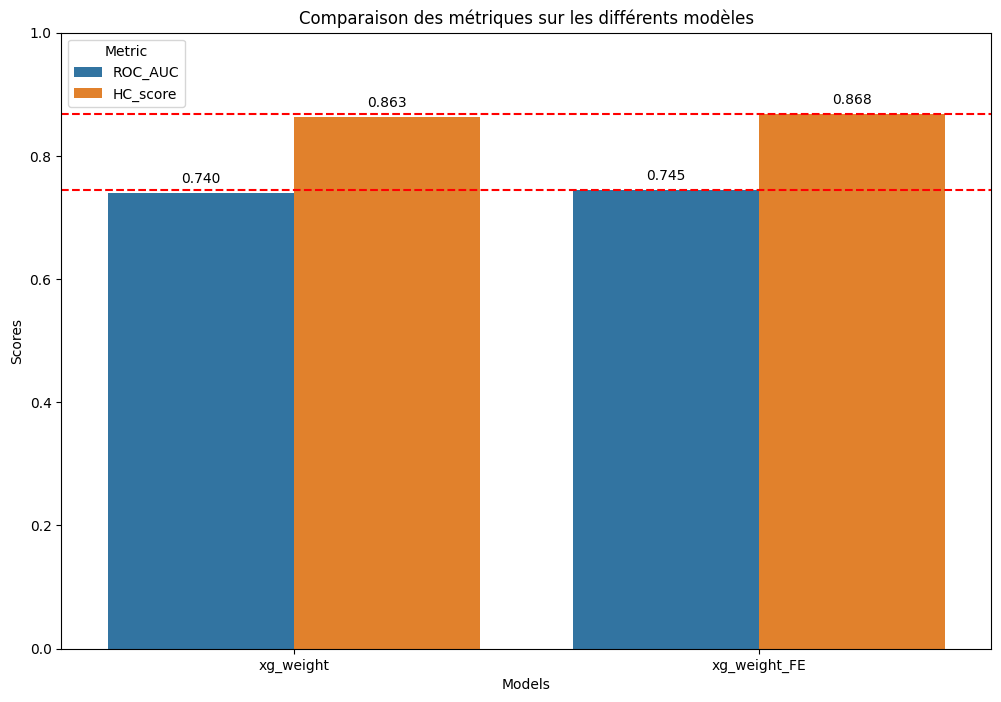

In [18]:
# Metrics labels
metrics = ['ROC_AUC', 'HC_score']

# Convert the dictionary to a DataFrame for easier plotting
d_plot = {key: d_res[key][0:2] for key in d_res if 'xg_weight' in key}


df = pd.DataFrame.from_dict(d_plot, orient='index', columns=metrics).sort_values(by='HC_score')
# df=df.iloc[:,:-1]
# df.drop('DummyClassifier',inplace=True)

df.reset_index(inplace=True)
df = df.rename(columns={'index': 'Model'})
max_HC_score  = df.HC_score.max()
max_AUC_score = df.ROC_AUC.max()


# Melt the DataFrame to a long format for seaborn
df = df.melt(id_vars='Model', var_name='Metric', value_name='Score')

# Create the plot
plt.figure(figsize=(12, 8))
ax=sns.barplot(data=df, x='Model', y='Score', hue='Metric')



# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Comparaison des métriques sur les différents modèles')
plt.legend(title='Metric')

for p in ax.patches[:-2]:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')

# Tracer une ligne en pointillé rouge au niveau du maximum de HC_score
plt.axhline(y=max_HC_score,              color='r', linestyle='--')
plt.axhline(y=max_AUC_score, color='r', linestyle='--')
# Show the plot
plt.ylim(0, 1)
plt.show()


### Conclusion 

Nous observons une amélioration des résultats du modèle de 0.005 pour le score AUC ROC et de 0.005 pour le score métier.

# Interprétabilité du modèle


Nous allons utiliser la library SHAP afin de visualiser l'importance de chaque variable. Ce module va nous permettre de calculer les shap values associés à chaque variable pour chaque individu. Elle représente le poids de la variable dans la prise de décision du modèle lors de la prédiction. Ainsi une valeur négative va entrainer la prédiction vers 0 et un poids positif va entrainer la variable vers 1.

In [19]:
from shap import TreeExplainer,summary_plot,decision_plot

# Create an Explainer object using the best pipeline
explainer = TreeExplainer(xg_weight_FE.best_estimator_)

ev = explainer.expected_value

sv = explainer.shap_values(X_train_scaled)



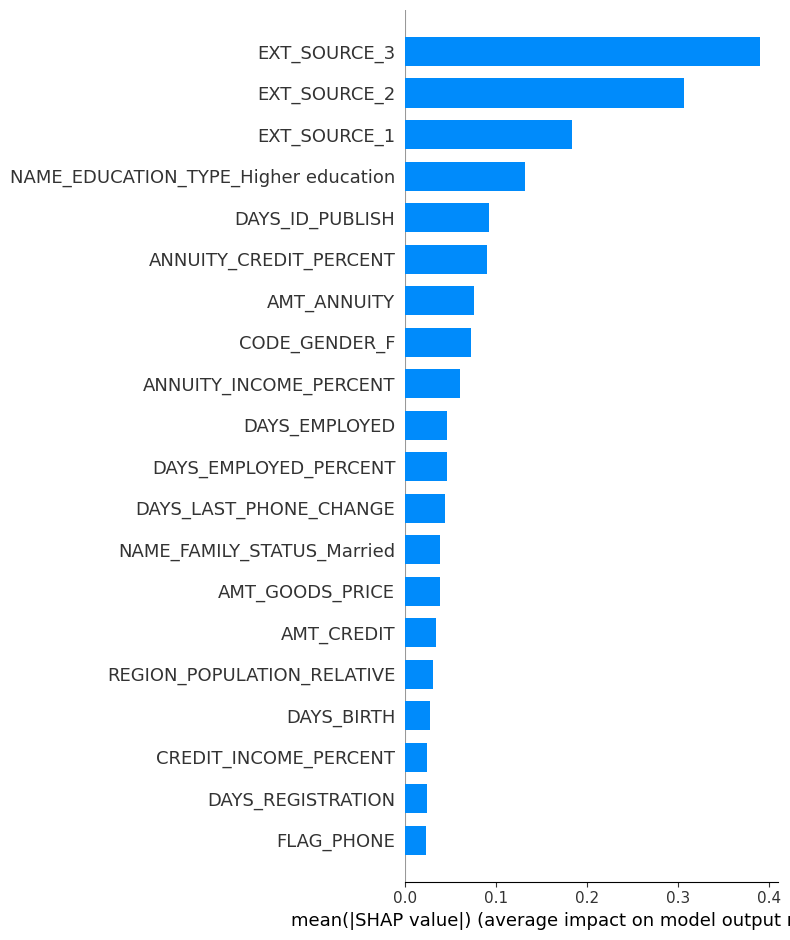

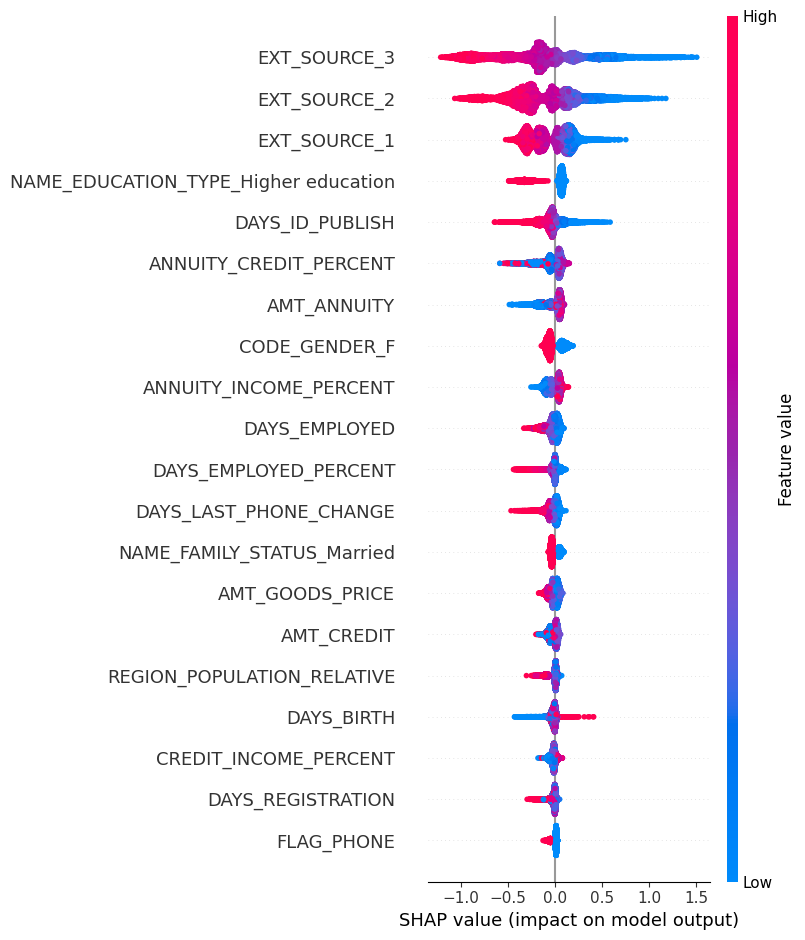

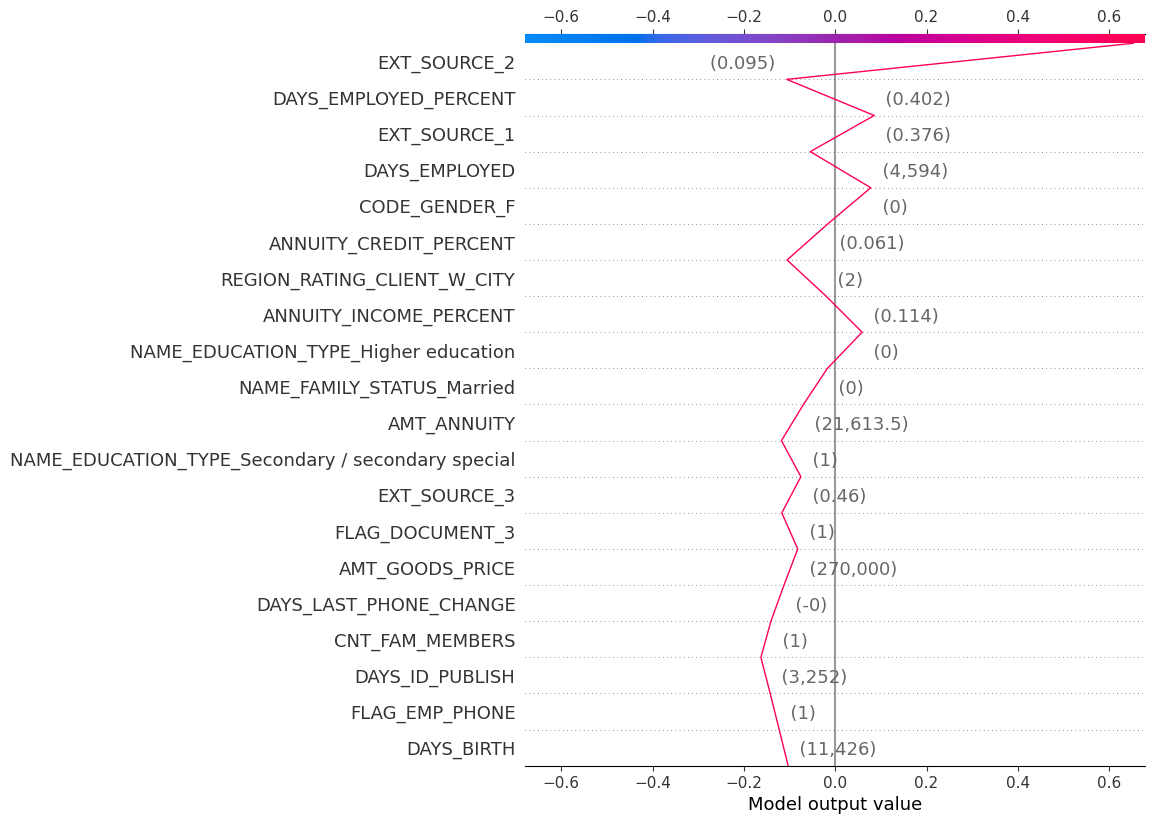

In [20]:
from shap import TreeExplainer,summary_plot,decision_plot
# Plot summary
summary_plot(sv, X_train_scaled, feature_names=X_train.columns.tolist(), plot_type='bar')


summary_plot(sv, X_train_scaled, feature_names=X_train.columns.tolist())

# Select an instance of df

select = 0

# Calculate SHAP values for the single instance
sv_sel = explainer.shap_values(X_test_scaled[select: select+1])

# Plot force plot for the instance
# display(shap.force_plot(explainer.expected_value, shap_values_instance.values[0] , instance, feature_names=X_train.columns.tolist()))
decision_plot(     ev,
                   sv_sel,
                   X_test
                   )


Modèle global : 
Nous observons que les poids des variables EXT_SOURCE_X et education_type sont parmis les valeurs les plus importantes du modèle. Ce qui fait sens puisque l'on peut estimer qu'avec un haut niveau d'étude va correspondre une situation probablement plus stable financièrement.


Modèle local : 
Sur une prédiction donnée unitaire, nous observons que EXT_SOURCE_2, EXT_SOURCE_1 et DAYS_EMPLOYED_PERCENT sont parmis les valeurs les plus importantes du modèle. EXT_SOURCE_2 "pousse" fortement la prédiction  vers la valeur 1 ce qui est logique car, comme vu lors de l'exploration de données, plus la valeur est faible, plus il y a un risque de défaut de paiement.